In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests as re
import urllib3

from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score

from datetime import datetime
from datetime import timedelta

url_train   = 'https://raw.githubusercontent.com/chattrapatchua/dsi10_project4/master/data/train.csv'
url_test    = 'https://raw.githubusercontent.com/chattrapatchua/dsi10_project4/master/data/test.csv'
url_weather = 'https://raw.githubusercontent.com/chattrapatchua/dsi10_project4/master/data/weather.csv'
url_spray   = 'https://raw.githubusercontent.com/chattrapatchua/dsi10_project4/master/data/spray.csv'

train   = pd.read_csv(url_train)
test    = pd.read_csv(url_test)
weather = pd.read_csv(url_weather)
spray   = pd.read_csv(url_spray)

In [3]:
# # Import the datasets to be used for this project
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
weather = pd.read_csv("./data/weather.csv")
spray = pd.read_csv("./data/spray.csv")

# 1. Data Cleaning & EDA

## 1.1 Train & test dataset

### Train

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [5]:
train.describe()

Block      Latitude     Longitude  AddressAccuracy  \
count  10506.000000  10506.000000  10506.000000     10506.000000   
mean      35.687797     41.841139    -87.699908         7.819532   
std       24.339468      0.112742      0.096514         1.452921   
min       10.000000     41.644612    -87.930995         3.000000   
25%       12.000000     41.732984    -87.760070         8.000000   
50%       33.000000     41.846283    -87.694991         8.000000   
75%       52.000000     41.954690    -87.627796         9.000000   
max       98.000000     42.017430    -87.531635         9.000000   

       NumMosquitos    WnvPresent  
count  10506.000000  10506.000000  
mean      12.853512      0.052446  
std       16.133816      0.222936  
min        1.000000      0.000000  
25%        2.000000      0.000000  
50%        5.000000      0.000000  
75%       17.000000      0.000000  
max       50.000000      1.000000

- 12 features
- Approx. 10,000 samples

In [6]:
train.head()

Date                                            Address  \
0  29/5/2007  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  29/5/2007  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  29/5/2007  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  29/5/2007    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  29/5/2007    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

### Test

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address                   116293 non-null object
Species                   116293 non-null object
Block                     116293 non-null int64
Street                    116293 non-null object
Trap                      116293 non-null object
AddressNumberAndStreet    116293 non-null object
Latitude                  116293 non-null float64
Longitude                 116293 non-null float64
AddressAccuracy           116293 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [8]:
test.describe()

Id          Block       Latitude      Longitude  \
count  116293.000000  116293.000000  116293.000000  116293.000000   
mean    58147.000000      41.131100      41.849389     -87.693658   
std     33571.041765      24.864726       0.106593       0.080699   
min         1.000000      10.000000      41.644612     -87.930995   
25%     29074.000000      18.000000      41.753411     -87.750938   
50%     58147.000000      39.000000      41.862292     -87.694991   
75%     87220.000000      61.000000      41.951866     -87.648860   
max    116293.000000      98.000000      42.017430     -87.531635   

       AddressAccuracy  
count    116293.000000  
mean          7.954357  
std           1.252733  
min           3.000000  
25%           8.000000  
50%           8.000000  
75%           9.000000  
max           9.000000

- 11 features (no NumMosquitos feature)
- Approx. 110k samples

In [9]:
test.head()

Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2   3  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3   4  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4   5  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

### Data Cleaning

#### Dropping features

In [10]:
# Drop NumMosquitos feature as it is not present in test.csv
train.drop(columns='NumMosquitos', inplace=True)

In [11]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'WnvPresent'],
      dtype='object')

In [12]:
# Address, Block, Street, AddressNumberAndStreet, AddressAccuracy, Trap can all be dropped
# These features are string data type, and give location based info.
# Location info. can be obtained through Latitude and Longitude
train.drop(columns=['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], inplace=True)

# Drop whatever was dropped for train.csv
test.drop(columns=['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], inplace=True)

In [13]:
# # 'Trap' is just the code of the trap, which is also the location
# # Since there is numerical data for the location, trap can be dropped
train.drop(columns=['Trap'], inplace=True)
test.drop(columns=['Trap'], inplace=True)

In [14]:
test.head()

Id        Date                 Species  Latitude  Longitude
0   1  2008-06-11  CULEX PIPIENS/RESTUANS  41.95469 -87.800991
1   2  2008-06-11          CULEX RESTUANS  41.95469 -87.800991
2   3  2008-06-11           CULEX PIPIENS  41.95469 -87.800991
3   4  2008-06-11        CULEX SALINARIUS  41.95469 -87.800991
4   5  2008-06-11         CULEX TERRITANS  41.95469 -87.800991

#### Changing data type

In [15]:
# Date feature is a string
# Change to date-time type
#train['Date'] = pd.to_datetime(train['Date'])
#train['Date'] = train['Date'].dt.strftime('%d/%m/%Y')
#train['Date'] = pd.to_datetime(train['Date'])
train['Date'] = pd.to_datetime(train['Date'], dayfirst=True, format='%d/%m/%Y')

#test['Date'] = pd.to_datetime(test['Date'])
test['Date'] = pd.to_datetime(test['Date'], yearfirst=True, format='%Y-%m-%d')

In [16]:
train.head()

Date                 Species   Latitude  Longitude  WnvPresent
0 2007-05-29  CULEX PIPIENS/RESTUANS  41.954690 -87.800991           0
1 2007-05-29          CULEX RESTUANS  41.954690 -87.800991           0
2 2007-05-29          CULEX RESTUANS  41.994991 -87.769279           0
3 2007-05-29  CULEX PIPIENS/RESTUANS  41.974089 -87.824812           0
4 2007-05-29          CULEX RESTUANS  41.974089 -87.824812           0

In [17]:
test.head()

Id       Date                 Species  Latitude  Longitude
0   1 2008-06-11  CULEX PIPIENS/RESTUANS  41.95469 -87.800991
1   2 2008-06-11          CULEX RESTUANS  41.95469 -87.800991
2   3 2008-06-11           CULEX PIPIENS  41.95469 -87.800991
3   4 2008-06-11        CULEX SALINARIUS  41.95469 -87.800991
4   5 2008-06-11         CULEX TERRITANS  41.95469 -87.800991

In [18]:
# Check to see if conversion was done correctly
# There was an issue with inconsistent parsing of the string 
train['Date'].dt.month.unique()

array([ 5,  6,  7,  8,  9, 10], dtype=int64)

In [19]:
test['Date'].dt.month.unique()

array([ 6,  7,  8,  9, 10], dtype=int64)

- Datetime conversion seems correct
- train.csv has data for only May to Oct
- test.csv has data for only Jun to Oct

### Splitting train.csv to training & testing set

In [20]:
# Split train.csv to training_set and testing_set
X = train[['Date', 'Species', 'Latitude', 'Longitude']]
y = train['WnvPresent']
X_training, X_testing, y_training, y_testing = train_test_split(X, y, stratify=y)

In [21]:
# Check out dimension for X_training
X_training.shape

(7879, 4)

### Preliminary EDA on training set

In [22]:
# Merge X_training and y_training for EDA
training = X_training.join(y_training)

- **Baseline**

In [23]:
# Get baseline accuracy score for predicting absence of virus
training['WnvPresent'].value_counts(normalize=True)

0    0.947582
1    0.052418
Name: WnvPresent, dtype: float64

- Baseline accuracy score for predicting absence of WNV is 94.76%
- It can be seen that this is a dataset with highly unbalanced classes.
- SMOTE will be used later on to deal with this oversampling issue.


- **WNV cases across time periods**

Text(0.5, 0, 'Year')

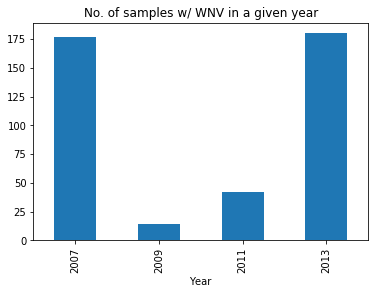

In [24]:
# See the number of WNV cases across year
ax = training.groupby(train['Date'].dt.year).sum()['WnvPresent'].plot(kind='bar')
ax.set_title('No. of samples w/ WNV in a given year')
ax.set_xlabel('Year')

Inference:
- 2007 & 2013 were the years with highest number  of samples found w/ WNV
- 2011 was the year with least

Text(0.5, 1.0, 'No. of samples w/ WNV in a given (year, month)')

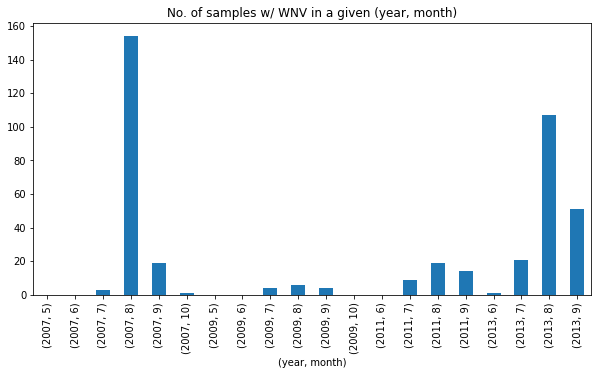

In [25]:
# See the number of WNV samples across months
ax = training.groupby([training['Date'].dt.year, training['Date'].dt.month]).sum()['WnvPresent'].plot(kind='bar', figsize=(10,5))
ax.set_xlabel('(year, month)')
ax.set_title('No. of samples w/ WNV in a given (year, month)')

Inference:
- Across the time period, July, August seems to have had the highest numbers of WNV carriers.
- July and August are the summer months for Chicago (https://www.tripsavvy.com/best-time-to-visit-chicago-4175898)

- **Species of mosquito and relation to WNV**

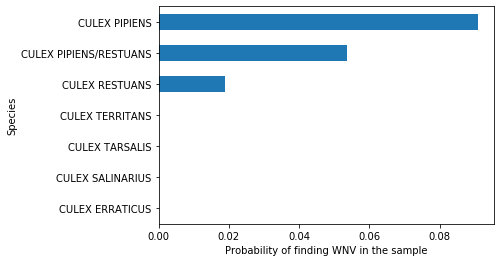

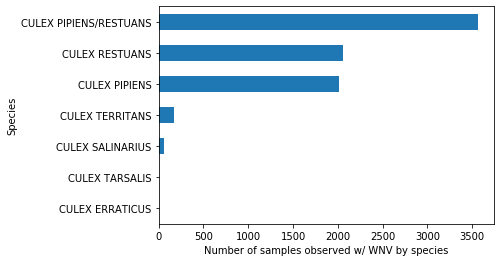

In [26]:
# Get a sense of the various species of mosquitos
# Some species could be carriers of the virus
ax = training.groupby('Species').mean()['WnvPresent'].sort_values(ascending=True).plot(kind='barh')
ax.set_xlabel('Probability of finding WNV in the sample')
plt.show()
ax = training.groupby('Species').count()['WnvPresent'].sort_values(ascending=True).plot(kind='barh')
ax.set_xlabel('Number of samples observed w/ WNV by species')
plt.show()

Inference:
- Culex Pipiens/Restuans species have highest probability of carrying WNV in Chicago.

## 1.2 Weather dataset

In [27]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB


In [28]:
weather.describe()

Station         Tmax         Tmin     DewPoint  ResultSpeed  \
count  2944.000000  2944.000000  2944.000000  2944.000000  2944.000000   
mean      1.500000    76.166101    57.810462    53.457880     6.960666   
std       0.500085    11.461970    10.381939    10.675181     3.587527   
min       1.000000    41.000000    29.000000    22.000000     0.100000   
25%       1.000000    69.000000    50.000000    46.000000     4.300000   
50%       1.500000    78.000000    59.000000    54.000000     6.400000   
75%       2.000000    85.000000    66.000000    62.000000     9.200000   
max       2.000000   104.000000    83.000000    75.000000    24.100000   

         ResultDir  
count  2944.000000  
mean     17.494905  
std      10.063609  
min       1.000000  
25%       7.000000  
50%      19.000000  
75%      25.000000  
max      36.000000

In [29]:
pd.set_option('max_columns', 500)
weather.head()

Station      Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  1/5/2007    83    50   67     14        51      56    0    2   
1        2  1/5/2007    84    52   68      M        51      57    0    3   
2        1  2/5/2007    59    42   51     -3        42      47   14    0   
3        2  2/5/2007    60    43   52      M        42      47   13    0   
4        1  3/5/2007    66    46   56      2        40      48    9    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall PrecipTotal StnPressure  \
0     448   1849             0      M        0           0        29.1   
1       -      -             M      M        M           0       29.18   
2     447   1850      BR     0      M        0           0       29.38   
3       -      -   BR HZ     M      M        M           0       29.44   
4     446   1851             0      M        0           0       29.39   

  SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6  
2    30.09         13.0          4     13.4  
3    30.08         13.3          2     13.4  
4    30.12         11.7          7     11.9

### Data Cleaning

In [30]:
# Change Date to date-time data type
#weather['Date'] = pd.to_datetime(weather['Date'])
#weather['Date'] = weather['Date'].dt.strftime('%d/%m/%Y')
#weather['Date'] = pd.to_datetime(weather['Date'])
weather['Date'] = pd.to_datetime(weather['Date'], dayfirst=True, format='%d/%m/%Y')

In [31]:
weather.tail()

Station       Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
2939        2 2014-10-29    49    40   45      M        34      42   20    0   
2940        1 2014-10-30    51    32   42     -4        34      40   23    0   
2941        2 2014-10-30    53    37   45      M        35      42   20    0   
2942        1 2014-10-31    47    33   40     -6        25      33   25    0   
2943        2 2014-10-31    49    34   42      M        29      36   23    0   

     Sunrise Sunset   CodeSum Depth Water1 SnowFall PrecipTotal StnPressure  \
2939       -      -               M      M        M           0       29.42   
2940     622   1649               0      M        0           0       29.34   
2941       -      -        RA     M      M        M           T       29.41   
2942     623   1647     RA SN     0      M      0.1        0.03       29.49   
2943       -      -  RA SN BR     M      M        M        0.04       29.54   

     SeaLevel  ResultSpeed  ResultDir AvgSpeed  
2939    30.07          8.5         29        9  
2940    30.09          5.1         24      5.5  
2941     30.1          5.9         23      6.5  
2942     30.2         22.6         34     22.9  
2943     30.2         21.7         34     22.6

In [32]:
# Drop Tmax and Tmin
# There is no info. on how long the temperature was at max/min, 
# and there is a Tavg already, which is a more appropriate feature
weather.drop(columns=['Tmax', 'Tmin'], inplace=True)

In [33]:
# From data dictionary, 'depart' is departure from normal
# It does not give much information, and a lot of values are missing
# Therefore, this column will be dropped
print('Amount of rows with missing data in Depart column:', weather[weather['Depart'] == 'M'].shape[0])
weather.drop(columns='Depart', inplace=True)

Amount of rows with missing data in Depart column: 1472


In [34]:
# DewPoint and WetBulb features are a measure of humidity, therefore should keep
# Heat, Cool is info. on the hotness/coolness on that day, which is given by the Temperature measurements already
# Sunrise, Sunset, SnowFall is also kind of related to the temperature 
weather.drop(columns=['Heat', 'Cool', 'Sunrise', 'Sunset', 'SnowFall'], inplace=True)

In [35]:
# Drop CodeSum column
# From the data dictionary, it is info. on weather phenomena
# However, the information is hard to interpret and the number of possible combinations is really high
# Also, there is a very unbalanced distribution, and therefore it is decided that this column will be dropped
print(weather['CodeSum'].value_counts())
weather.drop(columns='CodeSum', inplace=True)

                       1609
RA                      296
RA BR                   238
BR                      110
TSRA RA BR               92
BR HZ                    81
RA DZ BR                 65
TSRA RA                  43
HZ                       39
RA BR HZ                 38
TSRA                     34
RA DZ                    22
TSRA BR                  21
TS TSRA RA BR            19
RA HZ                    16
TS RA                    13
TSRA RA BR HZ            12
TS TSRA BR               10
DZ BR                    10
TS                       10
DZ BR HZ                  9
DZ                        8
TSRA BR HZ                8
TS RA BR                  8
TS TSRA BR HZ             7
RA DZ BR HZ               7
TS TSRA RA                7
TS TSRA                   7
TSRA RA BR VCTS           4
TSRA HZ                   4
                       ... 
RA FG+ BR                 1
RA BR FU                  1
TS TSRA RA VCTS           1
BR VCTS                   1
TSRA BR HZ FU       

In [36]:
# As high number of missing values in Depth and Water1 columns, drop these columns
print('Number of missing values in Depth column:', weather[weather['Depth'] == 'M'].shape[0])
print('Number of missing values in Water1 column:', weather[weather['Water1'] == 'M'].shape[0])
weather.drop(columns=['Depth', 'Water1'], inplace=True)

Number of missing values in Depth column: 1472
Number of missing values in Water1 column: 2944


In [37]:
# 'PrecipTotal' is the amount of rain in a 24 hr period
# The column dtype is a string, as some entries is 'T' meaning trace amt (according to the data dictionary)
weather['PrecipTotal'].values

array(['0', '0', '0', ..., '  T', '0.03', '0.04'], dtype=object)

In [38]:
# 'T' has whitespace in front, must use .strip() to clean it
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.strip())

# Convert 'T' entries to 0, and convert dtype to float
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.replace('T', '0.001'))
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda x: x.replace('M', '0'))
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

In [39]:
# Tavg (the average temperature on that day) has missing values
weather[weather['Tavg'] == 'M'].shape[0]

11

In [40]:
# Since there are only 11 missing values for Tavg out of 2944 entries, it is safe to drop the missing values
weather = weather[weather['Tavg'] != 'M']

# Convert Tavg dtype to float
weather['Tavg'] = weather['Tavg'].astype(float)

In [41]:
# Drop StnPressure, SeaLevel, ResultSpeed, ResultDir and AvgSpeed
# These are generic conditions which do not really relate to mosquito population
weather.drop(columns=['Station', 'StnPressure', 'SeaLevel'], inplace=True)

In [42]:
weather.dtypes

Date           datetime64[ns]
Tavg                  float64
DewPoint                int64
WetBulb                object
PrecipTotal           float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed               object
dtype: object

- All columns are now numerical type

In [43]:
weather.head()

Date  Tavg  DewPoint WetBulb  PrecipTotal  ResultSpeed  ResultDir  \
0 2007-05-01  67.0        51      56          0.0          1.7         27   
1 2007-05-01  68.0        51      57          0.0          2.7         25   
2 2007-05-02  51.0        42      47          0.0         13.0          4   
3 2007-05-02  52.0        42      47          0.0         13.3          2   
4 2007-05-03  56.0        40      48          0.0         11.7          7   

  AvgSpeed  
0      9.2  
1      9.6  
2     13.4  
3     13.4  
4     11.9

- As the weather info is taken across 2 different stations each day, calc. the average across the 2 stations.

In [44]:
weather = weather.groupby('Date').mean().reset_index()

In [45]:
weather.head()

Date  Tavg  DewPoint  PrecipTotal  ResultSpeed  ResultDir
0 2007-05-01  67.5      51.0        0.000         2.20       26.0
1 2007-05-02  51.5      42.0        0.000        13.15        3.0
2 2007-05-03  57.0      40.0        0.000        12.30        6.5
3 2007-05-04  58.0      41.0        0.001        10.40        8.0
4 2007-05-05  60.0      38.5        0.001        11.45        7.0

In [46]:
weather.shape

(1472, 6)

### Feature Engineering

**Rolling Averages**



*   Create rolling averages for 3, 7 and 14 days
*   Afer researching, 3, 7 and 14 days is the typical life-cycle of mosquito larvae https://www.mosquito.org/page/lifecycle



In [47]:
# Create rolling averages for Tavg
weather['Tavg_rolling3day']= weather['Tavg'].rolling(3).mean().rename(columns={'Tavg': 'Tavg_rolling3day'})
weather['Tavg_rolling3day'].fillna(70, inplace=True)
weather['Tavg_rolling7day']= weather['Tavg'].rolling(7).mean().rename(columns={'Tavg': 'Tavg_rolling7day'})
weather['Tavg_rolling7day'].fillna(70, inplace=True)
weather['Tavg_rolling14day']= weather['Tavg'].rolling(14).mean().rename(columns={'Tavg': 'Tavg_rolling14day'})
weather['Tavg_rolling14day'].fillna(70, inplace=True)

In [48]:
# Create rolling averages for DewPoint
weather['DewPoint_rolling3day']= weather['DewPoint'].rolling(3).mean().rename(columns={'DewPoint': 'DewPoint_rolling3day'})
weather['DewPoint_rolling3day'].fillna(55, inplace=True)
weather['DewPoint_rolling7day']= weather['DewPoint'].rolling(7).mean().rename(columns={'DewPoint': 'DewPoint_rolling7day'})
weather['DewPoint_rolling7day'].fillna(55, inplace=True)
weather['DewPoint_rolling14day']= weather['DewPoint'].rolling(14).mean().rename(columns={'DewPoint': 'DewPoint_rolling14day'})
weather['DewPoint_rolling14day'].fillna(55, inplace=True)

In [49]:
# Create rolling averages for PrecipTotal
#weather['PrecipTotal_rolling3day']= weather['PrecipTotal'].rolling(3).mean().rename(columns={'PrecipTotal': 'PrecipTotal_rolling3day'})
#weather['PrecipTotal_rolling3day'].fillna(0, inplace=True)
#weather['PrecipTotal_rolling7day']= weather['PrecipTotal'].rolling(7).mean().rename(columns={'PrecipTotal': 'PrecipTotal_rolling7day'})
#weather['PrecipTotal_rolling7day'].fillna(0, inplace=True)
#weather['PrecipTotal_rolling14day']= weather['PrecipTotal'].rolling(14).mean().rename(columns={'PrecipTotal': 'PrecipTotal_rolling14day'})
#weather['PrecipTotal_rolling14day'].fillna(0, inplace=True)

In [50]:
weather.head(20)

Date  Tavg  DewPoint  PrecipTotal  ResultSpeed  ResultDir  \
0  2007-05-01  67.5      51.0       0.0000         2.20       26.0   
1  2007-05-02  51.5      42.0       0.0000        13.15        3.0   
2  2007-05-03  57.0      40.0       0.0000        12.30        6.5   
3  2007-05-04  58.0      41.0       0.0010        10.40        8.0   
4  2007-05-05  60.0      38.5       0.0010        11.45        7.0   
5  2007-05-06  59.5      30.0       0.0000        14.10       10.5   
6  2007-05-07  66.0      40.0       0.0005         8.55       17.5   
7  2007-05-08  69.0      57.5       0.0005         2.60        9.5   
8  2007-05-09  69.5      59.5       0.0750         3.90        8.0   
9  2007-05-10  70.5      52.0       0.0000         1.35       13.0   
10 2007-05-11  61.0      43.0       0.0000        11.50       19.5   
11 2007-05-12  55.5      36.5       0.0000        12.55        2.0   
12 2007-05-13  56.5      32.5       0.0000         6.50       12.5   
13 2007-05-14  72.5      46.0       0.0000        15.50       21.0   
14 2007-05-15  69.0      56.0       0.4900         8.10       26.0   
15 2007-05-16  55.0      42.5       0.1050         7.90       36.0   
16 2007-05-17  53.0      32.0       0.0000        11.10        2.0   
17 2007-05-18  57.0      30.5       0.0000         4.40       23.5   
18 2007-05-19  68.0      38.0       0.0000        11.10       23.5   
19 2007-05-20  56.5      40.5       0.0900         9.50        3.5   

    Tavg_rolling3day  Tavg_rolling7day  Tavg_rolling14day  \
0          70.000000         70.000000          70.000000   
1          70.000000         70.000000          70.000000   
2          58.666667         70.000000          70.000000   
3          55.500000         70.000000          70.000000   
4          58.333333         70.000000          70.000000   
5          59.166667         70.000000          70.000000   
6          61.833333         59.928571          70.000000   
7          64.833333         60.142857          70.000000   
8          68.166667         62.714286          70.000000   
9          69.666667         64.642857          70.000000   
10         67.000000         65.071429          70.000000   
11         62.333333         64.428571          70.000000   
12         57.666667         64.000000          70.000000   
13         61.500000         64.928571          62.428571   
14         66.000000         64.928571          62.535714   
15         65.500000         62.857143          62.785714   
16         59.000000         60.357143          62.500000   
17         55.000000         59.785714          62.428571   
18         59.333333         61.571429          63.000000   
19         60.500000         61.571429          62.785714   

    DewPoint_rolling3day  DewPoint_rolling7day  DewPoint_rolling14day  
0              55.000000             55.000000              55.000000  
1              55.000000             55.000000              55.000000  
2              44.333333             55.000000              55.000000  
3              41.000000             55.000000              55.000000  
4              39.833333             55.000000              55.000000  
5              36.500000             55.000000              55.000000  
6              36.166667             40.357143              55.000000  
7              42.500000             41.285714              55.000000  
8              52.333333             43.785714              55.000000  
9              56.333333             45.500000              55.000000  
10             51.500000             45.785714              55.000000  
11             43.833333             45.500000              55.000000  
12             37.333333             45.857143              55.000000  
13             38.333333             46.714286              43.535714  
14             44.833333             46.500000              43.892857  
15             48.166667             44.071429              43.928571  
16             43.500000        

**Days since rain**

In [51]:
# create a column for the days since it last rained
weather["days_since_rain"] = 0
days = 0

for i in range(weather.shape[0]):
    if weather.loc[i,'PrecipTotal'] == 0:
        days = days + 1
        weather.loc[i,'days_since_rain'] = days
    else:
        weather.loc[i, 'days_since_rain'] = 0
        days=0

In [52]:
# Since the time lag (days since rain) is a more important feature, drop PrecipTotal
weather.drop(columns=['PrecipTotal'], inplace=True)

### EDA for Weather data

In [53]:
weather.groupby([weather['Date'].dt.year, weather['Date'].dt.month]).mean()

Tavg   DewPoint  ResultSpeed  ResultDir  Tavg_rolling3day  \
Date Date                                                                   
2007 5     64.516129  45.774194     8.566129  14.629032         64.612903   
     6     72.200000  56.600000     7.130000  14.800000         72.488889   
     7     74.193548  58.838710     6.069355  17.112903         73.801075   
     8     75.387097  64.096774     4.788710  14.080645         75.752688   
     9     68.916667  53.050000     7.121667  16.816667         68.816667   
     10    59.838710  47.080645     8.935484  20.806452         60.387097   
2008 5     56.322581  42.306452     8.293548  16.370968         55.817204   
     6     71.616667  57.333333     7.743333  20.266667         71.588889   
     7     74.806452  60.758065     6.848387  20.564516         74.446237   
     8     73.306452  59.419355     6.011290  15.000000         73.489247   
     9     67.000000  56.250000     5.636667  18.833333         67.622222   
     10    53.500000  40.564516     7.490323  20.903226         53.521505   
2009 5     60.758065  44.129032     7.127419  19.129032         60.559140   
     6     68.516667  55.400000     6.155000  15.116667         68.366667   
     7     70.403226  56.129032     5.812903  21.564516         70.252688   
     8     71.225806  58.806452     7.038710  15.451613         71.623656   
     9     65.983333  55.616667     5.488333  11.066667         66.122222   
     10    49.483871  41.580645     7.683871  19.564516         49.731183   
2010 5     62.419355  48.596774     7.109677  14.048387         61.500000   
     6     71.800000  60.350000     6.021667  17.783333         72.083333   
     7     78.354839  64.016129     6.232258  20.322581         78.145161   
     8     77.112903  63.564516     6.241935  20.129032         76.801075   
     9     65.833333  52.100000     7.441667  18.000000         66.483333   
     10    56.612903  40.177419     7.595161  21.725806         57.129032   
2011 5     59.016129  47.967742     9.211290  11.145161         58.064516   
     6     70.366667  57.483333     7.496667  14.966667         70.455556   
     7     79.951613  64.548387     5.282258  15.354839         79.763441   
     8     74.258065  61.967742     5.159677  16.548387         74.440860   
     9     63.050000  52.266667     7.221667  19.183333         63.727778   
     10    55.370968  42.177419     6.967742  21.725806         55.645161   
2012 5     65.887097  47.403226     7.708065  14.419355         65.591398   
     6     74.316667  53.733333     8.148333  17.600000         73.477778   
     7     82.000000  64.274194     6.353226  16.129032         82.016129   
     8     74.451613  58.241935     5.067742  17.161290         74.397849   
     9     65.316667  50.616667     7.073333  21.950000         66.000000   
     10    52.500000  40.580645     9.650000  22.080645         53.080645   
2013 5     61.887097  47.741935     7.756452  14.258065         60.924731   
     6     69.300000  56.466667     6.923333  13.233333         69.405556   
     7     74.129032  61.112903     6.538710  15.822581         74.150538   
     8     73.919355  59.887097     5.980645  16.677419         73.645161   
     9     68.066667  54.850000     6.953333  17.016667         68.594444   
     10    54.096774  44.016129     7.183871  20.241935         54.295699   
2014 5     61.919355  46.532258     8.282258  14.596774         61.408602   
     6     72.250000  58.050000     7.070000  16.516667         72.022222   
     7     71.645161  56.677419     7.140323  20.000000         71.833333   
     8     74.790323  62.225806     5.995161  16.790323         74.591398   
     9     65.250000  53.083333     5.828333  21.116667         65.872222   
     10    53.661290  42.354839     8.438710  21.370968         54.231183   

           Tavg_rolling7day  Tavg_rolling14day  DewPoint_rolling3day  \
Date Date                                                              
2007 5            65.

In [54]:
def plot_weather_trend(col_lst = weather.columns[1:4]):
    for col in col_lst:
        ax = weather.groupby([weather['Date'].dt.year, weather['Date'].dt.month]).mean()[col].sort_index().plot(kind='bar', figsize=(10,5))
        ax.set_ylabel(f'{col}')
        ax.set_xlabel('Year')
        plt.show()


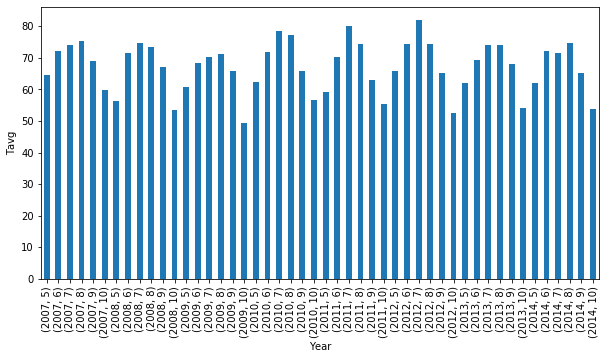

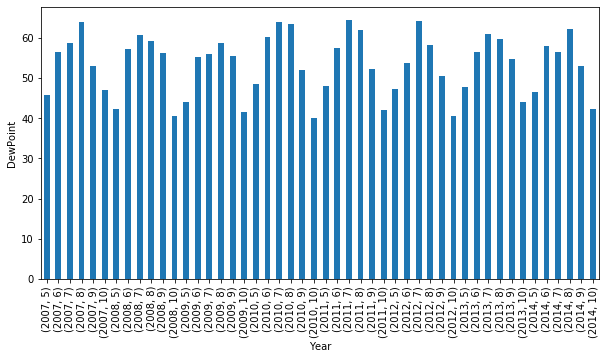

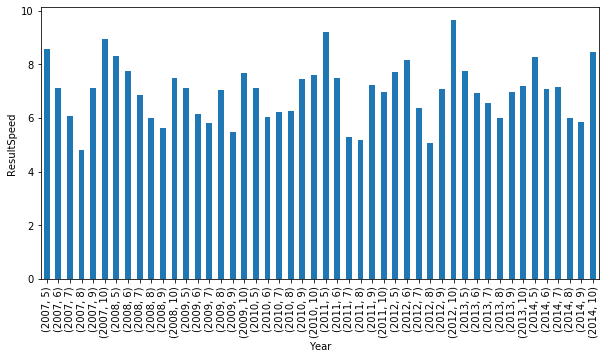

In [55]:
plot_weather_trend()

- There is clear seasonality for Tavg. In all years apart from 2014, temperatures peak in July and August
- For DewPoint, there is also a relatively clear seasonal aspect to it as well. July and August are for the most part the 2 most humid months of that year.
- The amount of rain varies a bit more compared to the other 2 features.

## 1.3 Spray dataset

In [56]:
spray.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [57]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [58]:
# The 'Time' column can be dropped as it is too much granularity
# The other datasets do not have a 'Time' column and ultimately it is too much information
spray.drop(columns='Time', inplace=True)

In [59]:
# Convert 'Date' column to date-time
spray['Date'] = pd.to_datetime(spray['Date'])

In [60]:
# See the average number of locations sprayed in a given month across the 2011 and 2013
spray.groupby(spray['Date'].dt.month).count()['Latitude']

Date
7    3809
8    7988
9    3038
Name: Latitude, dtype: int64

- According to spray data, pesticide is spayed on in July, August and September
- This reflects the fact that the highest number of mosquitos with WNV are found in these months

In [61]:
# See the number of locations sprayed in a given year
spray.groupby(spray['Date'].dt.year).count()[['Latitude', 'Longitude']]

Latitude  Longitude
Date                     
2011      2209       2209
2013     12626      12626

- In 2013, the number of locations with pesticide being sprayed is increased by approx. 6 times.
    - From 2209 locations in 2011, to 12626 locations in 2013

Text(0.5, 0, 'Year')

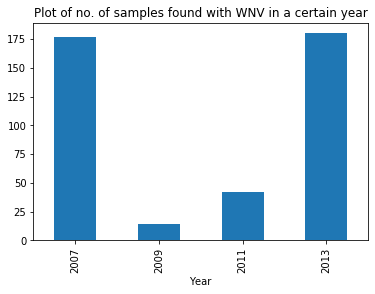

In [62]:
ax = training.groupby(train['Date'].dt.year).sum()['WnvPresent'].plot(kind='bar')
ax.set_title('Plot of no. of samples found with WNV in a certain year')
ax.set_xlabel('Year')

- In 2013, even though the amount of locations increased significantly, the number of mosquitos with WNV actually increased compared to 2011.
- Spraying data is given ony for 2011 and 2013

- **As there is no evident correlation between spraying and reduced WNV found in samples (since in 2013 the amount of sprayed locations was drastically increased, but the number of WNV carriers increased)**
- **the spray data will not be used.**


## 1.4 Preprocessing

**Training dataset**

In [63]:
training.head()

Date                 Species   Latitude  Longitude  WnvPresent
8020 2011-09-23  CULEX PIPIENS/RESTUANS  41.974689 -87.890615           0
6626 2011-07-15          CULEX RESTUANS  41.682587 -87.707973           0
8961 2013-07-19          CULEX RESTUANS  41.733643 -87.555510           0
73   2007-06-05  CULEX PIPIENS/RESTUANS  41.994469 -87.667736           0
9826 2013-08-22  CULEX PIPIENS/RESTUANS  41.659112 -87.538693           0

In [64]:
# Merge training dataset with weather data
final_training = pd.merge(training, weather, on='Date', how='left')

In [65]:
final_training.drop(columns=['Species'], inplace=True)

In [66]:
# Generate dummy cols for the species, dropping CULEX TERRITANS
#final_training = pd.get_dummies(data=final_training, columns=['Species'])
#final_training.drop(columns=['Species_CULEX TERRITANS'], inplace=True)

In [67]:
# Create final X & y training sets
features = [col for col in final_training.columns if (col != 'WnvPresent') & (col != 'Date')]
final_X_training = final_training[features]
final_y_training = final_training['WnvPresent']

In [68]:
final_X_training.head()

Latitude  Longitude  Tavg  DewPoint  ResultSpeed  ResultDir  \
0  41.974689 -87.890615  55.0      45.0         5.00       36.0   
1  41.682587 -87.707973  79.0      60.0         5.80        9.5   
2  41.733643 -87.555510  85.0      69.5        13.35       24.5   
3  41.994469 -87.667736  56.5      47.5         5.70        4.0   
4  41.659112 -87.538693  73.0      66.5         2.00       23.5   

   Tavg_rolling3day  Tavg_rolling7day  Tavg_rolling14day  \
0         59.166667         60.428571          61.428571   
1         73.666667         77.285714          77.571429   
2         85.833333         82.500000          79.321429   
3         63.833333         70.357143          69.535714   
4         76.833333         73.357143          71.678571   

   DewPoint_rolling3day  DewPoint_rolling7day  DewPoint_rolling14day  \
0             47.000000             50.285714              50.178571   
1             57.666667             61.928571              60.071429   
2             70.666667             68.357143              66.000000   
3             55.000000             58.428571              54.678571   
4             64.166667             59.357143              57.535714   

   days_since_rain  
0                0  
1                0  
2                0  
3                0  
4                0

In [69]:
final_y_training

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      1
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
7849    0
7850    0
7851    0
7852    0
7853    0
7854    0
7855    0
7856    0
7857    0
7858    0
7859    0
7860    0
7861    0
7862    0
7863    0
7864    0
7865    0
7866    0
7867    1
7868    0
7869    1
7870    0
7871    0
7872    0
7873    0
7874    0
7875    0
7876    0
7877    0
7878    0
Name: WnvPresent, Length: 7879, dtype: int64

In [70]:
# Perform SMOTE to deal with oversampling issue
# Initialize SMOTE
sm = SMOTE(random_state=55, ratio = 1.0)
final_X_training_sm, final_y_training_sm = sm.fit_sample(final_X_training, final_y_training)
final_X_training = pd.DataFrame(final_X_training_sm, columns=final_X_training.columns)
final_y_training = pd.DataFrame(final_y_training_sm, columns=['WnvPresent'])

In [71]:
final_y_training['WnvPresent'].value_counts()

1    7466
0    7466
Name: WnvPresent, dtype: int64

- Class is now balanced
- Baseline score is now 50%

In [72]:
#from google.colab import files

In [73]:
#final_X_training.to_csv('final_X_training.csv', index=False)
#files.download("final_X_training.csv")

#final_y_training.to_csv('final_y_training.csv', index=False)
#files.download("final_y_training.csv")
final_X_training.to_csv('./data/final_X_training.csv', index=False)
final_y_training.to_csv('./data/final_y_training.csv', index=False)

**Testing dataset**

In [74]:
#X_testing = pd.get_dummies(data=X_testing, columns=['Species'])
final_X_testing = pd.merge(X_testing, weather, on='Date', how='left')
final_X_testing.drop(columns=['Date', 'Species'], inplace=True)

In [75]:
final_X_testing.to_csv('./data/final_X_testing.csv', index=False)
#files.download("final_X_testing.csv")

y_testing.to_csv('./data/final_y_testing.csv', index=False)
#files.download("final_y_testing.csv")

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


**Test.csv**

In [76]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 5 columns):
Id           116293 non-null int64
Date         116293 non-null datetime64[ns]
Species      116293 non-null object
Latitude     116293 non-null float64
Longitude    116293 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.4+ MB


In [77]:
final_test = pd.merge(test, weather, on='Date', how='left')
#final_test =  pd.get_dummies(data=final_test, columns=['Species'])
final_test.drop(columns=['Date', 'Species'], inplace=True)
final_test.head()

Id  Latitude  Longitude  Tavg  DewPoint  ResultSpeed  ResultDir  \
0   1  41.95469 -87.800991  75.0      55.5         9.15       18.0   
1   2  41.95469 -87.800991  75.0      55.5         9.15       18.0   
2   3  41.95469 -87.800991  75.0      55.5         9.15       18.0   
3   4  41.95469 -87.800991  75.0      55.5         9.15       18.0   
4   5  41.95469 -87.800991  75.0      55.5         9.15       18.0   

   Tavg_rolling3day  Tavg_rolling7day  Tavg_rolling14day  \
0              71.5         74.785714              70.25   
1              71.5         74.785714              70.25   
2              71.5         74.785714              70.25   
3              71.5         74.785714              70.25   
4              71.5         74.785714              70.25   

   DewPoint_rolling3day  DewPoint_rolling7day  DewPoint_rolling14day  \
0                  58.5             64.571429              58.607143   
1                  58.5             64.571429              58.607143   
2                  58.5             64.571429              58.607143   
3                  58.5             64.571429              58.607143   
4                  58.5             64.571429              58.607143   

   days_since_rain  
0                1  
1                1  
2                1  
3                1  
4                1

In [78]:
final_test.to_csv('./data/final_test.csv', index=False)
#files.download("final_test.csv")

# 2. Map Visualization

In [79]:
# Load map data
mapdata = np.loadtxt("./data/mapdata_copyright_openstreetmap_contributors.txt")
traps = train[['Latitude', 'Longitude']]

Text(0.5, 0, 'Longitude')

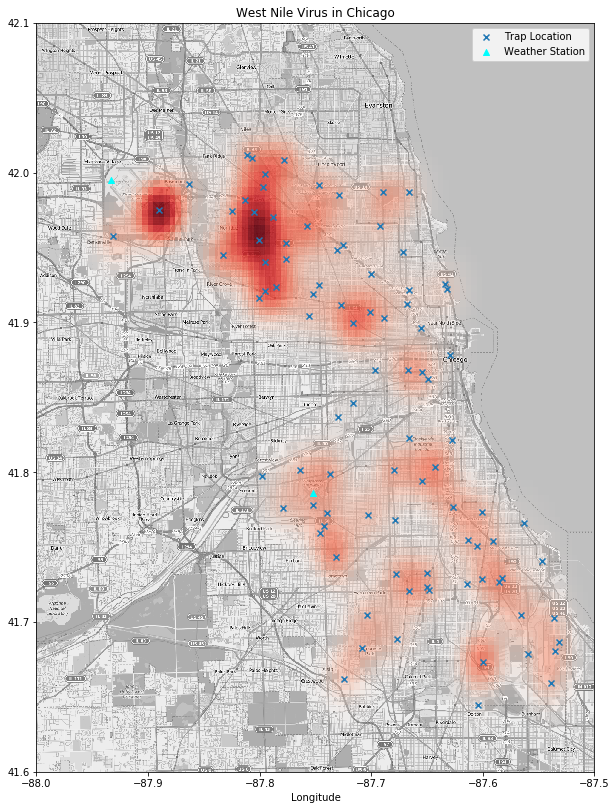

In [80]:
alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
trap_wnv = training[training['WnvPresent'] == 1]
trap_wnv = trap_wnv.groupby(['Date','Longitude', 'Latitude']).sum()['WnvPresent'].reset_index() # Groupby the cols, and sum incidences of WNV
X = trap_wnv[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

#Trap locations
locations = trap_wnv[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Trap Location')

# Weather locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='^', color='cyan', label='Weather Station')


plt.title('West Nile Virus in Chicago')
plt.legend(frameon=1)
plt.xlabel('Longitude')

# 3. Modelling

### Logistic Regression

In [81]:
lg = LogisticRegression()

In [82]:
lg.fit(final_X_training, final_y_training)
predicted = lg.predict(final_X_training)
print("ROC score on train dataset: ", roc_auc_score(final_y_training, predicted).round(3))

ROC score on train dataset:  0.666


C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [83]:
predicted = lg.predict(final_X_testing)
print("ROC score on test dataset: ", roc_auc_score(y_testing, predicted).round(3))

ROC score on test dataset:  0.635


### XGBoost

In [84]:
xgb = XGBClassifier(n_estimators = 500)
xgb.fit(final_X_training, final_y_training)

C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [85]:
predicted = xgb.predict(final_X_training)
print("ROC score on train dataset: ", roc_auc_score(final_y_training, predicted).round(3))

ROC score on train dataset:  0.921


In [86]:
predicted = xgb.predict(final_X_testing)
print("ROC score on test dataset: ", roc_auc_score(y_testing, predicted).round(3))

ROC score on test dataset:  0.704


In [87]:
final_X_testing

Latitude  Longitude  Tavg  DewPoint  ResultSpeed  ResultDir  \
0     41.798697 -87.736812  80.0      62.5         6.40       19.0   
1     41.948167 -87.730698  72.5      59.5         8.80       23.0   
2     41.921965 -87.632085  72.5      58.5         6.90       34.5   
3     41.837085 -87.729384  77.0      68.5         9.70       24.0   
4     41.963976 -87.691810  78.5      60.5         6.40        4.0   
5     41.990284 -87.797127  80.5      62.5         2.80       11.0   
6     41.932094 -87.700117  73.0      55.5         9.55        5.0   
7     41.682587 -87.707973  81.5      66.0         6.00       24.5   
8     41.825902 -87.667827  77.5      70.0         3.65       17.5   
9     41.692555 -87.598865  75.5      59.0         4.25       25.5   
10    41.923738 -87.785288  52.0      41.5        15.00       34.0   
11    41.726465 -87.585413  75.5      59.0         4.25       25.5   
12    41.678618 -87.559308  71.5      55.5         0.60       23.0   
13    41.960616 -87.777189  70.0      59.0         6.85       15.0   
14    41.954690 -87.800991  71.0      53.5         4.05        8.0   
15    41.732984 -87.649642  82.5      73.0         6.25       24.5   
16    41.801498 -87.763416  67.0      50.5         6.30        5.5   
17    42.006858 -87.675919  77.5      70.0         3.65       17.5   
18    41.793818 -87.654234  80.0      70.5         5.40       24.5   
19    41.726465 -87.585413  80.5      71.5         2.25        3.5   
20    41.891118 -87.654491  80.5      62.5         2.80       11.0   
21    41.891118 -87.654491  74.0      55.0         1.75       15.0   
22    41.776156 -87.778927  82.5      73.0         6.25       24.5   
23    41.954690 -87.800991  60.5      44.5         9.15        2.5   
24    41.688324 -87.676709  76.5      68.0         4.15        6.5   
25    41.940160 -87.794896  75.0      67.0         5.65       25.0   
26    41.974689 -87.890615  62.0      51.5         3.95        6.5   
27    41.662014 -87.724608  64.0      51.5        10.35       29.5   
28    41.822536 -87.666343  80.5      62.5         2.80       11.0   
29    41.836644 -87.677737  73.0      62.5         7.35       18.5   
...         ...        ...   ...       ...          ...        ...   
2597  41.911824 -87.726737  72.0      60.0         5.55        6.5   
2598  41.726465 -87.585413  71.5      64.5         3.55        1.0   
2599  41.846075 -87.716277  73.0      55.5         9.55        5.0   
2600  41.973845 -87.805059  55.0      45.0         5.00       36.0   
2601  41.775051 -87.655356  80.5      62.5         2.80       11.0   
2602  41.775051 -87.655356  80.5      62.5         2.80       11.0   
2603  41.797616 -87.797894  77.5      70.0         3.65       17.5   
2604  41.984809 -87.728492  72.0      60.0         5.55        6.5   
2605  41.960616 -87.777189  79.0      60.0         5.80        9.5   
2606  41.799282 -87.585487  80.5      62.5         2.80       11.0   
2607  41.686398 -87.531635  74.5      65.5         7.60       23.0   
2608  41.801179 -87.679447  72.5      58.5         6.90       34.5   
2609  41.846075 -87.716277  78.0      64.5         4.05       10.0   
2610  41.732984 -87.649642  72.0      60.0         5.55        6.5   
2611  42.017430 -87.687769  74.0      55.0         1.75       15.0   
2612  42.017430 -87.687769  74.0      55.0         1.75       15.0   
2613  41.673408 -87.599862  79.5      65.5         8.40       20.5   
2614  41.912563 -87.668055  64.0      55.5         8.95       29.0   
2615  41.999129 -87.795585  77.5      59.5         2.50       23.0   
2616  41.682587 -87.707973  71.0      53.5         4.05        8.0   
2617  41.750498 -87.605294  59.0      51.0         6.80       29.5   
2618  41.912563 -87.668055  72.0      60.0         5.55        6.5   
2619  41.680946 -87.535198  76.5      68.0         4.60        6.0   
2620  41.798697 -87.736812  56.5      42.5         1.85        4.0   
2621  42.006858 -87.675919  56.5      42.5         1.85        4.0   
2622  41.737052 -